# **Representation of Coarse Mode Particles in GFDL-ESM4 and MIROC6**

***Name*** *Katarina Andersen*\
***E-mail:*** *katarian@student.uio.no*\
***Assistant:*** *Gabriel Freitas (group 1)*\
***Course:*** *FORCeS eScience course 2020*\
***Date:*** *20-12-2020*

## **ABSTRACT**
In this project, we are investigating how GFDL-ESM4 and MIROC6 represent the mass concentration of Coarse Mode Particles (CMPs) by comparing the model output to observations obtained from stations located in Phoenix ( Arizona), Big Bend National Park (Texas), Washington D.C. and Acadia National Park-McFarland Hill (Maine). The aim is to study the correlation between the model output and the observations of the monthly mean mass concentration, the yearly mean, the yearly average for each month and the yearly average for each season. We defined a moderate correlation to be a value between 0.5 and 0.7, and a very good correlation to be anything above 0.7. Anything below 0.5 was categorized as no correlation, and especially negative correlation was disgarded as bad correlation. The results in this project suggests that the monthly mean and the yearly mean is misrepresented in the models. GFDL-ESM4 had a moderate correlation with the observations in Phoenix, Washington D.C. and Acadia National Park when studying the multiyear average for each month, which translated to very good correlation when studying the multiyear average for each season. MIROC6 had a moderate correlation with the observations at Big Bend National Park, both for the multiyear average for each month and each season.

## **INTRODUCTION**

Aerosol particles in climate models can be characterized into 4 size modes, with coarse mode particles (CMPs) being aerosol particles with diameters larger than 1.0 $\mu$m **(1)**. These particles are mainly produced by mechanical processes, with origins such as sea spray emitted from the ocean, mineral dust and primary bioaerosols (e.g. pollen). 

We are to study the representation of coarse particles in models, and are therefore comparing model outputs with observed mass concentration. Throughout this project, CMPs will be referred to as aerosol particles with a diameter larger than 2.5 $\mu$m up to 10 $\mu$m, as the observation data lacked information on pm1.0. As the mass concentration of aerosol particles with diameters larger than 2.5 $\mu$m is much higher than that of aerosol particles with a diameter between 1 $\mu$m and 2.5 $\mu$m, we believe that this will not affect the information we will gather about the CMPs. 

Why is it so important to study the model representation of the CMPs? For example, if the CMPs have an impact on the optical depth and is wrongly represented in the model then the model represents the optical depth wrong, which can have large effects on the results of the climate feedbacks.

## **METHOD**

### **Study area and study period**

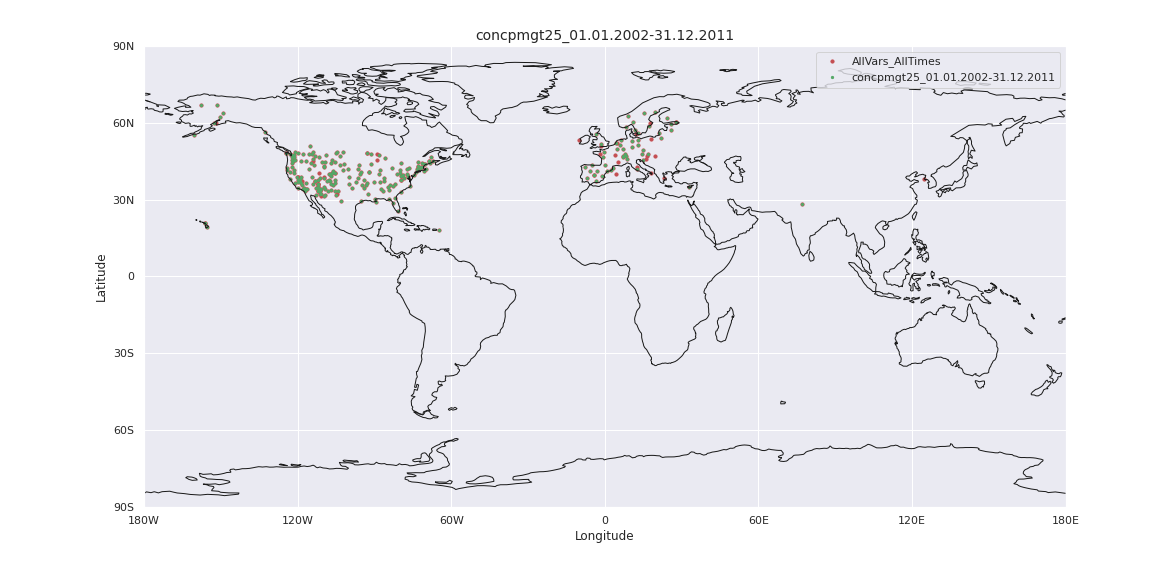

In [1]:
from IPython.display import Image
Image(filename='/home/4a726423-2d69c2-2d4ee4-2da665-2d1e313c39f43e/map.png')

The map above shows all the locations of all the available stations measuring observed values of daily mass concentration of pm2.5 and pm10. As shown, most of the stations are located in either North America or Europe. The chosen study sites for this project are Phoenix (Arizona), Big Bend National Park (Texas), Washington D.C. and Acadia National Park-McFarland Hill (Maine). Phoenix is the fifth largest city in the United States, located in the desert with a population of 1.66 milion, and Washington D.C. is the capital with a population of about almost 706 000, located at the east coast. To compare the stations at these two cities, we tried to locate national parks with approximately same terrestrial conditions, with Big Bend being located in between deserts and Acadia being located at the east coast.

The chosen study period for this project is January 2002 to January 2012. The measurments from Phoenix started in the middle of 2001, and there lacked data from 2013. To avoid too many `NaN`s when computing )and as the models used for this project have historical run going up to 2014) the choice for the study period was easily made.

### **Data**

The following packages was imported and used in this project:

In [2]:
import pyaerocom as pya                                   # To read observational data
pya.change_verbosity('critical', log=pya.print_log)

from warnings import filterwarnings                       # To remove all warnings when running code
filterwarnings('ignore')

import pandas as pd                                       # To gather the extracted data in dataframe
import matplotlib.pyplot as plt                           # For plotting
import seaborn as sns                                     # For plotting
import xarray as xr                                       # To open and reading files
import datetime                                           # For sorting pandas dataframe
import numpy as np                                        # Math tool
sns.set()                                                 # Setting seaborn layout as default when plotting

* **Observational data**

The observational data on the mass concentration of pm10 and pm2.5 used for the analysis is gathered from the **European Monitoring and Evaluation Programme database (EBAS)**, a database developed by the Norwegian Institute for Air Research (NILU) and the Norwegian Meteorological Institute (MET). The data was extracted using the following pyaerocom version: 
    
    

In [3]:
pya.__version__

'0.10.0rc1'

Collecting the data from the directory ***shared-ns-1000k/obsdata/EBAS*** in the jupyterhub:

In [4]:
try:
    pya.const.add_ungridded_obs(obs_id='EBAS', 
                            data_dir=f'{pya.const.HOMEDIR}/shared-ns1000k/obsdata/EBAS', 
                            reader=pya.io.ReadEbas, 
                            check_read=True)
except Exception as e:
    print(e)

In [5]:
#Reading in ungridded mass concentration of pm10 and pm2.5
reader = pya.io.ReadUngridded()
data = reader.read('EBAS', ['concpm10', 'concpm25'])

In [6]:
# Setting flagged values to all NaNs
data.set_flags_nan(inplace=True);

As pm2.5 refers to all particles with an aerodynamical diameter less 2.5 $\mu$m, and pm10 refers to all particles with an aerodynamical diameter less than 10 $\mu$m, we must subtract the mass concentration of pm2.5 from the mass concentration of pm10  to get the mass concentration of the coarse particles.

In [7]:
coarse_pm = data.colocate_vardata(var1='concpm10', 
                                  data_id1 = 'EBAS',
                                  var2='concpm25',
                                  data_id2='EBAS',
                                  match_stats_how='closest',
                                  match_stats_tol_km=1,
                                  merge_how='eval',
                                  merge_eval_fun='EBAS;concpm10-EBAS;concpm25',
                                  var_name_out='concpmgt25',
                                  data_id_out='EBAS',
                                  var_unit_out='ug m-3',
                                  resample_how='mean',
                                  apply_time_resampling_constraints=True)

Further on, we can collect the data from the chosen study areas and define the study period. We also want to extract the longitude and latitude of the study areas as they are needed when collecting the model data.

In [8]:
# Collecting the data from the stations

phoenix = coarse_pm.to_station_data('Phoenix', vars_to_convert='concpmgt25')
bbnp = coarse_pm.to_station_data('Big Bend National Park-K-Bar (TX04)', vars_to_convert='concpmgt25')
wdc = coarse_pm.to_station_data('Washington D.C.', vars_to_convert='concpmgt25')
anpmh = coarse_pm.to_station_data('Acadia National Park-McFarland Hill (ME98)', vars_to_convert='concpmgt25')

In [63]:
# Collecting the longitude and latitude from each station

placement = {'Phoenix': (phoenix['longitude'], phoenix['latitude']),
            'Big Bend National Park': (bbnp['longitude'], bbnp['latitude']),
            'Washington D.C.': (wdc['longitude'], wdc['latitude']),
            'Acadia National Park-McFarland Hill': (anpmh['longitude'], anpmh['latitude'])}
lonlat = pd.DataFrame(placement).set_index(pd.Index(['longitude', 'latitude']))

,Phoenix,Big Bend National Park,Washington D.C.,Acadia National Park-McFarland Hill
longitude,-112.0958,-103.1772,-77.0344,-68.2608
latitude,33.5038,29.3022,38.8762,44.3772


In [64]:
# Slicing the data into the chosen study period

phoenix = phoenix['concpmgt25']['2002-01-01':'2012-01-01']
bbnp = bbnp['concpmgt25']['2002-01-01':'2012-01-01']
wdc = wdc['concpmgt25']['2002-01-01':'2012-01-01']
anpmh = anpmh['concpmgt25']['2002-01-01':'2012-01-01']

The data from each site was gathered in to one pandas DataFrame. Next, the monthly mean was calculated

In [65]:
data = {'phoenix': phoenix, 'bbnp': bbnp, 'wdc': wdc, 'anpmh': anpmh}
obs_daily = pd.DataFrame(data)
obs_monthly = obs_daily.resample('M').mean()

`obs_monthly` was saved as *«observation_monthly.csv»*

* **Geophysical Fluid Dynamics Laboratory's Earth System Model 4 (GFDL-ESM4)**

The model data that is to be compared with the observational data need to contain the mass mixing ratio of both pm2.5 and pm10. One of the models that contain the information needed is Geophysical Fluid Dynamics Laboratory's Earth System Model 4 (GFDL-ESM4). The period for the model data's historical run is from 1950 to 2014.

In [66]:
path = '/home/4a726423-2d69c2-2d4ee4-2da665-2d1e313c39f43e/'

# GFDL-ESM4 data from 1950-2014
GFDL_pm25_path_f1950 = path + 'shared-new-ns9252k-for-ns1000k/ESGF/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/historical/r1i1p1f1/AERmon/mmrpm2p5/gr1/v20190726/mmrpm2p5_AERmon_GFDL-ESM4_historical_r1i1p1f1_gr1_195001-201412.nc'
GFDL_pm10_path_f1950 = path + 'shared-new-ns9252k-for-ns1000k/ESGF/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/historical/r1i1p1f1/AERmon/mmrpm10/gr1/v20190726/mmrpm10_AERmon_GFDL-ESM4_historical_r1i1p1f1_gr1_195001-201412.nc'

In [67]:
# Open directory using xarray
G_pm25_f1950 = xr.open_mfdataset(GFDL_pm25_path_f1950)
G_pm10_f1950 = xr.open_mfdataset(GFDL_pm10_path_f1950)

After opening the file using xarray, the variables `G_pm25_f1950` and `G_pm10_f1950` must be sliced to get the study period of our choosing.

In [68]:
#Slice the GFDL-ESM4 data
start = '2002-01-01'
end = '2012-01-01'

G_pm10 = G_pm10_f1950.sel(time=slice(start,end))
G_pm25 = G_pm25_f1950.sel(time=slice(start,end))

Now, the data from the chosen study sites are extracted. Here, we specify that the level we collected our data from is to be the level closest to the surface.

In [69]:
#PHOENIX - GFDL-ESM4
level = G_pm10['lev'].values[0] #using the first level, the ax is positive downwards
long1=248
lati1=33.5

G_pm10_phoenix = G_pm10.sel(lon=long1, lat=lati1, method='nearest', lev=level)['mmrpm10'].values
G_pm25_phoenix = G_pm25.sel(lon=long1, lat=lati1, method='nearest', lev=level)['mmrpm2p5'].values

In [70]:
#BIG BEND NATIONAL PARK - GFDL-ESM4
long2=360.0-103.177
lati2=29.3022

G_pm10_bbnp = G_pm10.sel(lon=long2, lat=lati2, method='nearest', lev=level)['mmrpm10'].values
G_pm25_bbnp = G_pm25.sel(lon=long2, lat=lati2, method='nearest', lev=level)['mmrpm2p5'].values

In [71]:
#WASHINGTON D.C. - GFDL-ESM4
long3=360.0-77.0344
lati3=38.8762

G_pm10_wdc = G_pm10.sel(lon=long3, lat=lati3, method='nearest', lev=level)['mmrpm10'].values
G_pm25_wdc = G_pm25.sel(lon=long3, lat=lati3, method='nearest', lev=level)['mmrpm2p5'].values

In [72]:
#ACADIA NATIONAL PARK-MCFARLAND HILL - GFDL-ESM4
long4=360.0-68.2608
lati4=44.3772

G_pm10_anpmh = G_pm10.sel(lon=long4, lat=lati4, method='nearest', lev=level)['mmrpm10'].values
G_pm25_anpmh = G_pm25.sel(lon=long4, lat=lati4, method='nearest', lev=level)['mmrpm2p5'].values

The time the measurments were taken must also be extracted. This was exectued by the following:

In [73]:
# Extracting the time the measurments were taken
timelist_gfdl=[]
n1 = len(G_pm10.time.values)
for i in range(0, n1):
    timeval = str(G_pm10.time.values[i])
    string = timeval.split()
    timelist_gfdl.append(string[0])

Further on, the extracted data was gathered into pandas DataFrames.

In [74]:
#Phoenix
data1 = {'Time': timelist_gfdl, 'PM10 [kg kg-1]': G_pm10_phoenix, 'PM25 [kg kg-1]': G_pm25_phoenix}
phoenix_gfdl = pd.DataFrame(data1)

#Big Bend National Park
data2 = {'Time': timelist_gfdl, 'PM10 [kg kg-1]': G_pm10_bbnp, 'PM25 [kg kg-1]': G_pm25_bbnp}
bbnp_gfdl = pd.DataFrame(data2)

#Washington D.C.
data3 = {'Time': timelist_gfdl, 'PM10 [kg kg-1]': G_pm10_wdc, 'PM25 [kg kg-1]': G_pm25_wdc}
wdc_gfdl = pd.DataFrame(data3)

#Acadia National Park-McFarland Hill
data4 = {'Time': timelist_gfdl, 'PM10 [kg kg-1]': G_pm10_anpmh, 'PM25 [kg kg-1]': G_pm25_anpmh}
anpmh_gfdl = pd.DataFrame(data4)

Lastly, the mass concentration was calculated by multiplying the mass mixing ratio from the model data with surface air density = 1.225 kg/m$^{3}$. In order to get $\mu$g/m$^{3}$ we multiply with $10^9$. This will not affect the correlation value between the model data and the observational data, but as the data is now in the same units it allows for a much neater comparison. The mass concentration from each site was gathered into one dataframe

In [75]:
# multiplying with surface air density = 1.2754 kg/m3
#multiplying with 10^9 to get ug/m3

#Phoenix
mc_pm10 = phoenix_gfdl['PM10 [kg kg-1]']*1.2754*10**9
mc_pm25 = phoenix_gfdl['PM25 [kg kg-1]']*1.2754*10**9
phoenix_mccp = (mc_pm10 - mc_pm25)

#Big Bend National Park
mc_pm10 = bbnp_gfdl['PM10 [kg kg-1]']*1.2754*10**9
mc_pm25 = bbnp_gfdl['PM25 [kg kg-1]']*1.2754*10**9
bbnp_mccp = (mc_pm10 - mc_pm25)

#Washington D.C.
mc_pm10 = wdc_gfdl['PM10 [kg kg-1]']*1.2754*10**9
mc_pm25 = wdc_gfdl['PM25 [kg kg-1]']*1.2754*10**9
wdc_mccp = (mc_pm10 - mc_pm25)

#Acadia National Park-McFarland Hill
mc_pm10 = anpmh_gfdl['PM10 [kg kg-1]']*1.2754*10**9
mc_pm25 = anpmh_gfdl['PM25 [kg kg-1]']*1.2754*10**9
anpmh_mccp = (mc_pm10 - mc_pm25)

data = {'Time': wdc_gfdl['Time'], 'phoenix': phoenix_mccp, 'bbnp': bbnp_mccp, 'wdc': wdc_mccp, 'anpmh': anpmh_mccp}
gfdl_monthly = pd.DataFrame(data)

gfdl_monthly['Datetime'] = pd.to_datetime(gfdl_monthly['Time'])
gfdl_monthly = gfdl_monthly.set_index('Datetime')
gfdl_monthly = gfdl_monthly.drop(['Time'], axis=1)

`gfdl_monthly` was saved as *«gfdl_monthly.csv»*

* **the Model for Interdisiplinary Research on Climate 6 (MIROC6)**

The second model to be compared to the observational data is the historical run of MIROC6. The data from MIROC6 is devided in two files, one containing historical runs from 2000 to 2009 and the other from 2010 to 2014. From MIROC6, the values of the mass mixing ratio of pm2.5 and pm10 and the time the values were measured was collected.

In [76]:
path = '/home/4a726423-2d69c2-2d4ee4-2da665-2d1e313c39f43e/'

#MIROC6 data from 2000 to 2009
M_pm25_path_f2000 = path + 'shared-new-ns9252k-for-ns1000k/ESGF/CMIP6/CMIP/MIROC/MIROC6/historical/r1i1p1f1/AERmon/mmrpm2p5/gn/v20200918/mmrpm2p5_AERmon_MIROC6_historical_r1i1p1f1_gn_200001-200912.nc'
M_pm10_path_f2000 = path + 'shared-new-ns9252k-for-ns1000k/ESGF/CMIP6/CMIP/MIROC/MIROC6/historical/r1i1p1f1/AERmon/mmrpm10/gn/v20200918/mmrpm10_AERmon_MIROC6_historical_r1i1p1f1_gn_200001-200912.nc'

#MIROC6 data from 2010 until 2014
M_pm25_path_u2014 = path + 'shared-new-ns9252k-for-ns1000k/ESGF/CMIP6/CMIP/MIROC/MIROC6/historical/r1i1p1f1/AERmon/mmrpm2p5/gn/v20200918/mmrpm2p5_AERmon_MIROC6_historical_r1i1p1f1_gn_201001-201412.nc'
M_pm10_path_u2014 = path + 'shared-new-ns9252k-for-ns1000k/ESGF/CMIP6/CMIP/MIROC/MIROC6/historical/r1i1p1f1/AERmon/mmrpm10/gn/v20200918/mmrpm10_AERmon_MIROC6_historical_r1i1p1f1_gn_201001-201412.nc'

In [77]:
M_pm25_f2000 = xr.open_mfdataset(M_pm25_path_f2000)
M_pm10_f2000 = xr.open_mfdataset(M_pm10_path_f2000)

M_pm25_u2014 = xr.open_mfdataset(M_pm25_path_u2014)
M_pm10_u2014 = xr.open_mfdataset(M_pm10_path_u2014)

After opening the file, the data from our chosen study period must be extracted. As there are two sets of MIROC6 datafiles, the first one has to be sliced from 2002 to 2009, whilst the other must be sliced from 2010 to 2012.

In [78]:
#slicing the data
start1 = '2002-01-01'
end1 = '2012-01-01'

start2 = '2010-01-01'
end2 = '2009-12-31'

M_pm10_u2009 = M_pm10_f2000.sel(time=slice(start1,end2))
M_pm25_u2009 = M_pm25_f2000.sel(time=slice(start1,end2))

M_pm10_f2010 = M_pm10_u2014.sel(time=slice(start2,end1))
M_pm25_f2010 = M_pm25_u2014.sel(time=slice(start2,end1))

We now extract the values from our study sites Phoenix, Big Bend National Park, Washington D.C. and Acadia National Park-McFarland hill. It also demands that we specify a certain level to obtain the data from, and so we chose the first level as this is closest to the surface.

In [79]:
#Phoenix - MIROC6
level = M_pm10_u2009['lev'].values[0]
long1=248
lati1=33.5

#From 2002 to 2009
M_pm10_u2009_phoenix = M_pm10_u2009.sel(lon=long1, lat=lati1, method='nearest', lev=level)['mmrpm10'].values
M_pm25_u2009_phoenix = M_pm25_u2009.sel(lon=long1, lat=lati1, method='nearest', lev=level)['mmrpm2p5'].values

#From 2010 to 2012
M_pm10_f2010_phoenix = M_pm10_f2010.sel(lon=long1, lat=lati1, method='nearest', lev=level)['mmrpm10'].values
M_pm25_f2010_phoenix = M_pm25_f2010.sel(lon=long1, lat=lati1, method='nearest', lev=level)['mmrpm2p5'].values

# Merging the arrays
M_pm10_phoenix = np.concatenate((M_pm10_u2009_phoenix, M_pm10_f2010_phoenix))
M_pm25_phoenix = np.concatenate((M_pm25_u2009_phoenix, M_pm25_f2010_phoenix))

In [80]:
#Big Bend National Park
long2=360.0-103.177
lati2=29.3022

#From 2002 to 2009
M_pm10_u2009_bbnp = M_pm10_u2009.sel(lon=long2, lat=lati2, method='nearest', lev=level)['mmrpm10'].values
M_pm25_u2009_bbnp = M_pm25_u2009.sel(lon=long2, lat=lati2, method='nearest', lev=level)['mmrpm2p5'].values

#From 2010 to 2014
M_pm10_f2010_bbnp = M_pm10_f2010.sel(lon=long2, lat=lati2, method='nearest', lev=level)['mmrpm10'].values
M_pm25_f2010_bbnp = M_pm25_f2010.sel(lon=long2, lat=lati2, method='nearest', lev=level)['mmrpm2p5'].values

# Merging the arrays, obs! losing the date stamp
M_pm10_bbnp = np.concatenate((M_pm10_u2009_bbnp, M_pm10_f2010_bbnp))
M_pm25_bbnp = np.concatenate((M_pm25_u2009_bbnp, M_pm25_f2010_bbnp))

In [81]:
#Washington D.C.
long3=360.0-77.0344
lati3=38.8762

#From 2002 to 2009
M_pm10_u2009_wdc = M_pm10_u2009.sel(lon=long3, lat=lati3, method='nearest', lev=level)['mmrpm10'].values
M_pm25_u2009_wdc = M_pm25_u2009.sel(lon=long3, lat=lati3, method='nearest', lev=level)['mmrpm2p5'].values

#From 2010 to 2014
M_pm10_f2010_wdc = M_pm10_f2010.sel(lon=long3, lat=lati3, method='nearest', lev=level)['mmrpm10'].values
M_pm25_f2010_wdc = M_pm25_f2010.sel(lon=long3, lat=lati3, method='nearest', lev=level)['mmrpm2p5'].values

# Merging the arrays, obs! losing the date stamp
M_pm10_wdc = np.concatenate((M_pm10_u2009_wdc, M_pm10_f2010_wdc))
M_pm25_wdc = np.concatenate((M_pm25_u2009_wdc, M_pm25_f2010_wdc))

In [82]:
#ACADIA NATIONAL PARK-MCFARLAND HILL
long4=360.0-68.2608
lati4=44.3772

#From 2002 to 2009
M_pm10_u2009_anpmh = M_pm10_u2009.sel(lon=long4, lat=lati4, method='nearest', lev=level)['mmrpm10'].values
M_pm25_u2009_anpmh = M_pm25_u2009.sel(lon=long4, lat=lati4, method='nearest', lev=level)['mmrpm2p5'].values

#From 2010 to 2014
M_pm10_f2010_anpmh = M_pm10_f2010.sel(lon=long4, lat=lati4, method='nearest', lev=level)['mmrpm10'].values
M_pm25_f2010_anpmh = M_pm25_f2010.sel(lon=long4, lat=lati4, method='nearest', lev=level)['mmrpm2p5'].values

# Merging the arrays, obs! losing the date stamp
M_pm10_anpmh = np.concatenate((M_pm10_u2009_anpmh, M_pm10_f2010_anpmh))
M_pm25_anpmh = np.concatenate((M_pm25_u2009_anpmh, M_pm25_f2010_anpmh))

The date stamp was lost when mergin the arrays, thus we must collect the date stamp by the following

In [83]:
timelist_miroc1=[]
n2 = len(M_pm10_u2009.time.values)
for i in range(0, n2):
    timeval = str(M_pm10_u2009.time.values[i])
    string = timeval.split('T')
    timelist_miroc1.append(string[0])

timelist_miroc2=[]
n3 = len(M_pm10_f2010.time.values)
for i in range(0,n3):
    timeval = str(M_pm10_f2010.time.values[i])
    string = timeval.split('T')
    timelist_miroc2.append(string[0])
    
timelist_miroc1 = np.array(timelist_miroc1)
timelist_miroc2 = np.array(timelist_miroc2)
timelist_miroc = np.concatenate((timelist_miroc1, timelist_miroc2))

The collected data is gathered in pandas DataFrames

In [84]:
#Phoenix
data1 = {'Time': timelist_miroc, 'PM10 [kg kg-1]': M_pm10_phoenix, 'PM25 [kg kg-1]': M_pm25_phoenix}
phoenix_miroc = pd.DataFrame(data1)

#Big Bend National Park
data2 = {'Time': timelist_miroc, 'PM10 [kg kg-1]': M_pm10_bbnp, 'PM25 [kg kg-1]': M_pm25_bbnp}
bbnp_miroc = pd.DataFrame(data2)

#Washington D.C.
data3 = {'Time': timelist_miroc, 'PM10 [kg kg-1]': M_pm10_wdc, 'PM25 [kg kg-1]': M_pm25_wdc}
wdc_miroc = pd.DataFrame(data3)

#Acadia National Park-McFarland Hill
data4 = {'Time': timelist_miroc, 'PM10 [kg kg-1]': M_pm10_anpmh, 'PM25 [kg kg-1]': M_pm25_anpmh}
anpmh_miroc = pd.DataFrame(data4)

To convert the values of the mass mixing ratio of pm2.5 and pm10, we multiply with the air density at the surface  ~ 1.2754 kg/m$^3$. This gives us a measure of kg/m$^3$, and thus to convert it to $\mu$g/m$^3$ we multiply with $10^9$

In [85]:
# multiplying with surface air density = 1.2754 kg/m3
#multiplying with 10^9 to get ug/m3

mc_pm10 = phoenix_miroc['PM10 [kg kg-1]']*1.2754*10**9
mc_pm25 = phoenix_miroc['PM25 [kg kg-1]']*1.2754*10**9
phoenix_mccp = (mc_pm10 - mc_pm25)

mc_pm10 = bbnp_miroc['PM10 [kg kg-1]']*1.2754*10**9
mc_pm25 = bbnp_miroc['PM25 [kg kg-1]']*1.2754*10**9
bbnp_mccp = (mc_pm10 - mc_pm25)

mc_pm10 = wdc_miroc['PM10 [kg kg-1]']*1.2754*10**9
mc_pm25 = wdc_miroc['PM25 [kg kg-1]']*1.2754*10**9
wdc_mccp = (mc_pm10 - mc_pm25)

mc_pm10 = anpmh_miroc['PM10 [kg kg-1]']*1.2754*10**9
mc_pm25 = anpmh_miroc['PM25 [kg kg-1]']*1.2754*10**9
anpmh_mccp = (mc_pm10 - mc_pm25)

In [86]:
data = {'Time': wdc_miroc['Time'], 'phoenix': phoenix_mccp, 'bbnp': bbnp_mccp, 'wdc': wdc_mccp, 'anpmh': anpmh_mccp}
miroc_monthly = pd.DataFrame(data)

miroc_monthly['Datetime'] = pd.to_datetime(miroc_monthly['Time'])
miroc_monthly = miroc_monthly.set_index('Datetime')
miroc_monthly = miroc_monthly.drop(['Time'], axis=1)

`miroc_monthly` was saved as *«miroc_monthly.csv»*

### **Preparing for Statistical Analysis**

As a scientist using the representation of coarse mode particles in GFDL-ESM4 or MIROC6, you are not necessarily interested in the correlation of just the monthly mean as this is very specific. Thus, it is also benifitial to look at other correlations such as the correlation of the yearly average, the correlation of the multiyear average for each month (here sometimes referred to as multimonthly average)  and the correlation of the multiyear average for each season (here sometimes referred to as multiseasonal average).
In the following, it is shown how the data is sorted to allow such comparisons, starting of by calculating the yearly average.

In [87]:
#Calculating the yearly mean
obs_yearly =  obs_monthly.resample('Y').mean()
gfdl_yearly = gfdl_monthly.resample('Y').mean()
miroc_yearly = miroc_monthly.resample('Y').mean()

To calculate the multimonthly average, the data needed to be categorized by month before using the `groupby` function and calculating the mean

In [98]:
#Calculating the multimonthly average

#Observation data
obs_monthly['Month'] = obs_monthly.index.strftime('%b') 
obs_multimonthly = obs_monthly[['Month','phoenix','bbnp','wdc','anpmh']].groupby('Month').mean()

#GFDL-ESM4
gfdl_monthly['Month'] = gfdl_monthly.index.strftime('%b') 
gfdl_multimonthly = gfdl_monthly[['Month','phoenix','bbnp','wdc','anpmh']].groupby('Month').mean()

#MIROC6
miroc_monthly['Month'] = miroc_monthly.index.strftime('%b') 
miroc_multimonthly = miroc_monthly[['Month','phoenix','bbnp', 'wdc','anpmh']].groupby('Month').mean()

To calculate the multiseasonal average, the data must be sorted into seasons. The winter season includes the months December, January, February, the spring season includes the months March, April and May. Summertime includes June, July and August, and lastly fall includes the months September, October and November.

In [99]:
#Observation data
season=[]
for i in range(len(obs_monthly['phoenix'])):
    month = obs_monthly['Month'][i]
    if month == 'Dec' or month == 'Jan' or month == 'Feb':
        season.append('DJF')
    if month == 'Mar' or month == 'Apr' or month == 'May':
        season.append('MAM')
    if month == 'Jun' or month == 'Jul' or month == 'Aug':
        season.append('JJA')
    if month == 'Sep' or month == 'Oct' or month == 'Nov':
        season.append('SON')
        
obs_monthly['Season'] = season
obs_multiseasonal = obs_monthly[['Season','phoenix','bbnp','wdc','anpmh']].groupby('Season').mean()

In [100]:
#GFDL-ESM4
season=[]
for i in range(len(gfdl_monthly['phoenix'])):
    month = gfdl_monthly['Month'][i]
    if month == 'Dec' or month == 'Jan' or month == 'Feb':
        season.append('DJF')
    if month == 'Mar' or month == 'Apr' or month == 'May':
        season.append('MAM')
    if month == 'Jun' or month == 'Jul' or month == 'Aug':
        season.append('JJA')
    if month == 'Sep' or month == 'Oct' or month == 'Nov':
        season.append('SON')
        
gfdl_monthly['Season'] = season
gfdl_multiseasonal = gfdl_monthly[['Season','phoenix','bbnp','wdc','anpmh']].groupby('Season').mean()

In [101]:
#MIROC6
season=[]
for i in range(len(miroc_monthly['phoenix'])):
    month = miroc_monthly['Month'][i]
    if month == 'Dec' or month == 'Jan' or month == 'Feb':
        season.append('DJF')
    if month == 'Mar' or month == 'Apr' or month == 'May':
        season.append('MAM')
    if month == 'Jun' or month == 'Jul' or month == 'Aug':
        season.append('JJA')
    if month == 'Sep' or month == 'Oct' or month == 'Nov':
        season.append('SON')
        
miroc_monthly['Season'] = season
miroc_multiseasonal = miroc_monthly[['Season','phoenix','bbnp','wdc','anpmh']].groupby('Season').mean()

### **Statistical Analysis**

In this project, the Pearson Correlation (referred to as correlation) was calculated. The Pearson Correlation is a measurment of strength and direction of linear relationship between two continous variables, and ranges from +1 to -1. A positive correlation indicates that when variable A increases, so does variable B. A negative correlation indicates that when variable A increases, variable B decreases. The magnitude of the correlation indicates how strong this relationship is.

## **RESULTS**

### **Monthly mass concentration comparison**

##### **Figure 1**

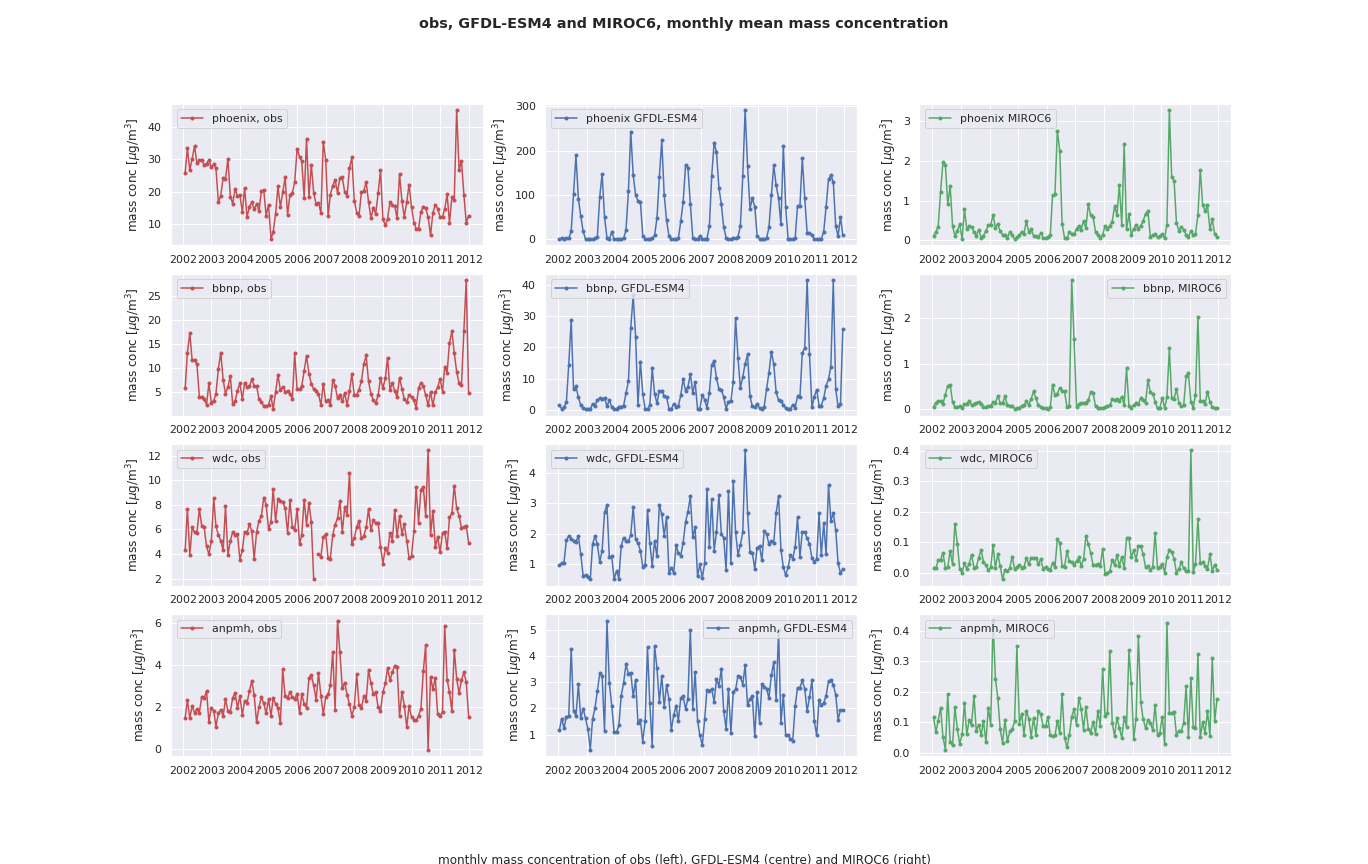

In [24]:
from IPython.display import Image
Image(filename='/home/4a726423-2d69c2-2d4ee4-2da665-2d1e313c39f43e/monthly_obs_GFDL-ESM4_MIROC6.png')

From the plot shown in figure 1, we can compare the monthly mean average of CMPs of the models and the observations over the period 2002 to january 2012. It seems as though MIROC6 consistantly underestimates the mass concentration of CMPs at the sites that were studied, while GFDL-ESM4 overestimates the concentration at Phoenix and Big Bend National Park and underestimates at the Washington D.C. site. The concentration produced by GFDL-ESM4 at Acadia National Park-McFarland Hill is of the same order as the concentration shown in the observations.

Studying the plots for the monthly mean conentration we can compare the observation to the GFDL-ESM4 at Phoenix and Big Bend National Park, and it seems as though the maximum values for the model tries to compensate for the months with no mass concentration of CMPs. In the plots for the Washington D.C. site, the GFDL-ESM4, with a fluctuation between 0 and 10 $\mu$g/m$^3$, shows lower mass concentration values than the observations, with a fluctuation between 3 and 10 $\mu$g/m$^3$ (with the exception of two maximas of ~11 $\mu$g/m$^3$ and ~12.5 $\mu$g/m$^3$). The plots for the site at Acadia National Park-McFarland Hill shows that the model seems to have a higher fluctuation in the period 2002 to 2007, but seems to be well represented in terms of the magnitude of the mass concentration of CMPs from 2007 to 2012.

When comparing MIROC6 to the observations we see that the MIROC6 produces a monthly average mass concentration of CMPs of an order less than compared to the observations. The MIROC6 data at the Phoenix site seems to show the same tendencies as the GFDL-ESM4 data; trying to compensate months with low to no mass concentration with months with high mass concentration

##### **Table 1: statistical properties of observations, GFDL-ESM4 and MIROC6**

| | | PHOENIX | | | BBNP | |
| --- | --- | --- | --- | --- | --- | --- |
| | **Observations** | **GFDL-ESM4** | **MIROC6** | **Observations** | **GFDL-ESM4** | **MIROC6** |
| **mean** | 19.61 | 52.53 | 0.48 | 6.42 | 6.77 |0.24 |
| **std** | 7.33 | 67.36 | 0.58 | 3.98 | 8.52 | 0.37 |
| **median** | 18.58 | 15.17 | 0.28 | 5.53 | 3.91 |0.14 |

| | | WDC | | | ANPMH | |
| --- | --- | --- | --- | --- | --- | --- |
| | **Observations** | **GFDL-ESM4** | **MIROC6** | **Observations** | **GFDL-ESM4** | **MIROC6** |
| **mean** | 6.18 | 1.71 | 0.04 | 2.50 | 2.31 | 0.12 |
| **std** | 1.68 | 0.81 | 0.047 | 0.96 | 0.97 | 0.08 |
| **median** | 5.96 | 1.65 | 0.03 | 2.39 | 2.34 | 0.10 |

Table 1 shows the statistical properties at each station for the observations, GFDL-ESM4 and MIROC6. It shows that the GFDL-ESM4 has the highest mean and standard deviation of mass conentration at the Phoenix site, but has lower median than the observations. This is to be expected as the plot comparing the monthly average mass concentration (figure 1) showed many months with zero mass concentration which was compensated by high concentration of mass concentration on the other months. If we multiply the statistical properties of the MIROC6 data at the site at Phoenix, we would see almost the same properties as suggested by figure 1. 

Comparing the statistical properties for the GFDL-ESM4 with the observations at Big Bend National Park, we see that the mean is almost the same. GFDL-ESM4 has a higher standard deviation and a lower median. If multiplied with 10 (to get the magnitude of the statistical properties in the same order as GFDL-ESM4 and the observations), then the MIROC6 data would have almost the same standard deviation as the observations, but a lower mean and median.

At the Washington D.C. site, the mean, standard deviation and median for GFDL-ESM4 and MIROC6 is lower than the observed (even if multiplying the MIROC6 data with 10). Judging by statistical properties at Acadia National Park-McFarland Hill, the GFDL-ESM4 is very accurate at portraying the observations, and MIROC6$*$10 is not far off either.

##### **Figure 2**


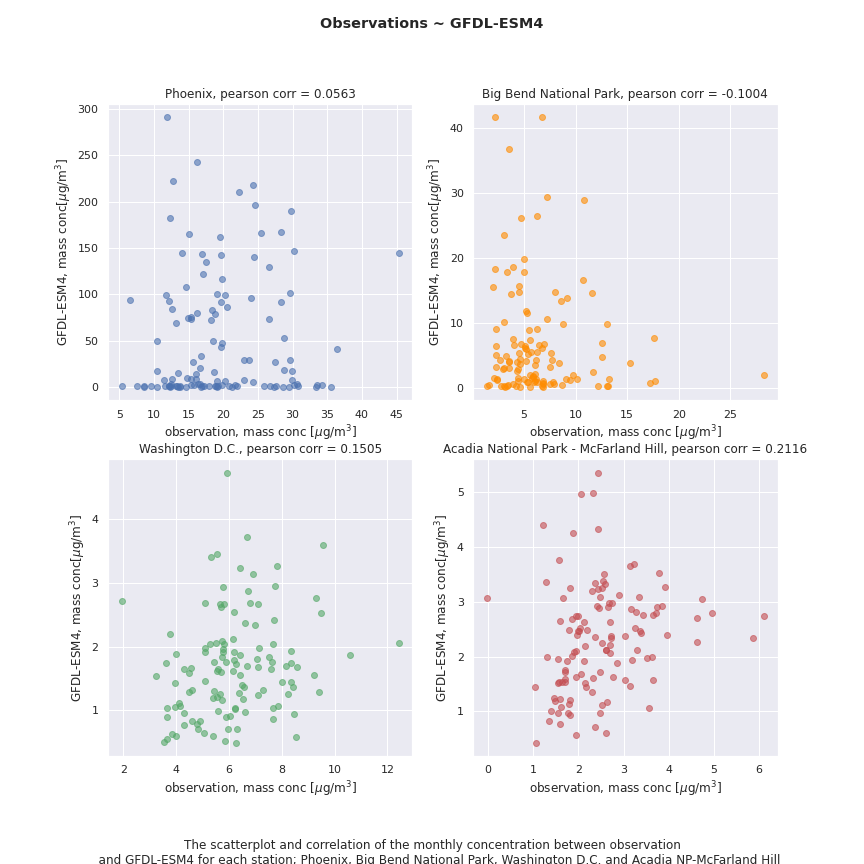

In [3]:
from IPython.display import Image
Image(filename='/home/4a726423-2d69c2-2d4ee4-2da665-2d1e313c39f43e/obs-gfdl-monthly.png')

Figure 2 shows the correlation between the observations and the GFDL-ESM4 data. We see that Phoenix has the lowest correlation of 0.056, Big Bend National Park has a negative correlation of -0.10, Washington D.C. has a correlation of 0.15, and Acadia National Park-McFarland Hill has the highest correlation with a value of 0.21.

##### **Figure 3**

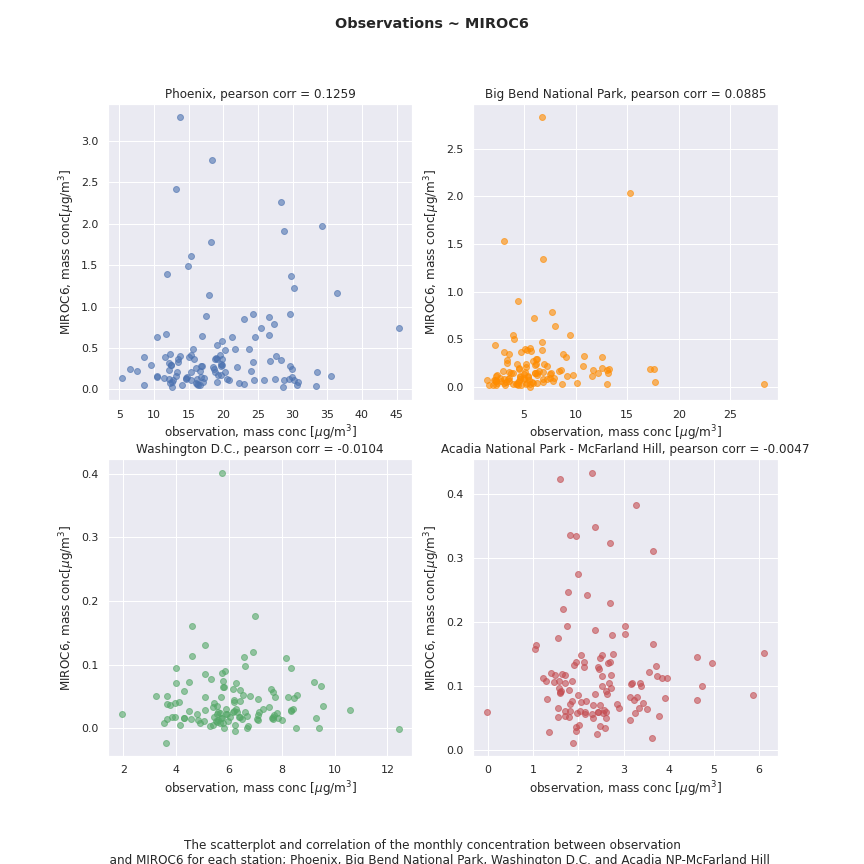

In [4]:
from IPython.display import Image
Image(filename='/home/4a726423-2d69c2-2d4ee4-2da665-2d1e313c39f43e/obs-miroc-monthly.png')

Figure 3 shows the correlation between the data from MIROC6 and the data from the observations. Phoneix has the strongest positive correlation of 0.13, Big Bend National Park have a positive correlation of 0.09, Washington D.C. has the strongest negative correlation with a value of -0.01, and Acadia National Park-McFarland Hill has the overall weakest correlation of -0.005

### **Yearly mass concentration comparison**

##### **Figure 4**

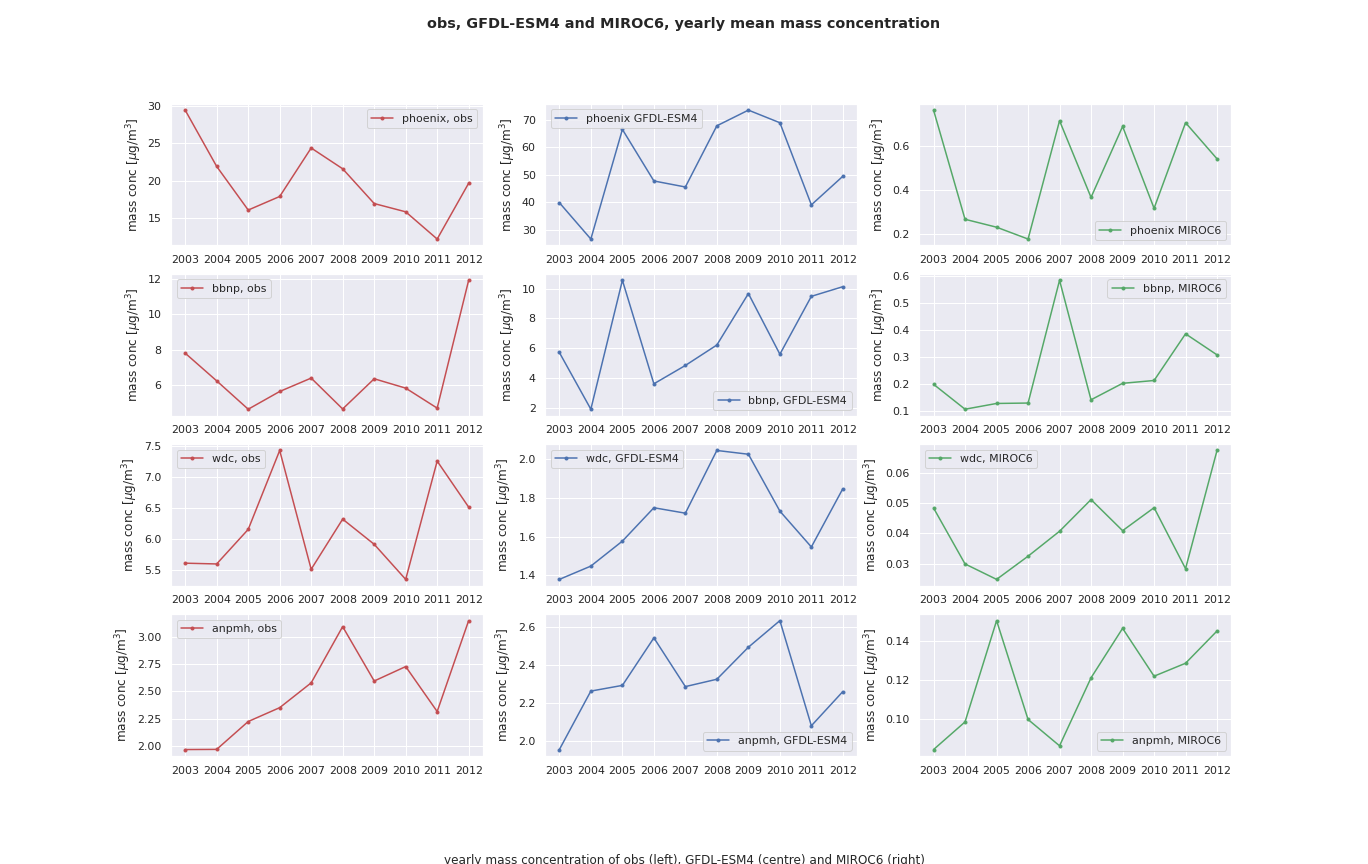

In [12]:
from IPython.display import Image
Image(filename='/home/4a726423-2d69c2-2d4ee4-2da665-2d1e313c39f43e/yearly_obs_GFDL-ESM4_MIROC6.png')

The display of the yearly mean mass concentration of CMPs are shown in figure 4. Studying the plot, we find that for the Phoenix site, there is no coherent trend when comparing the models to the observations. The observation data shows a negative trend in yearly concentration from 2007 to 2011, whilst GFDL-ESM4 shows high values in 2008 and 2010 and even a maximum in 2009. MIROC6 shows no negative trend either, and rather that the yearly average mass concentration increases and decreases every other year in the period 2006 to 2012. Both the observation data and MIROC6 has their maximum values in the first year.

There is no coherent trend between the models and the observations for the station at Big Bend National Park, but GFDL-ESM4 does show a high value for the mass concentration in 2012, where the observation data has its maximum. At the station Washington D.C. the observation data shows a maximum in 2006, whilst GFDL-ESM4 has a maximum in 2008 and MIROC has a maximum in 2012.

For the station at Acadia National Park-McFarland Hill, both models and the observation have its lowest yearly average value at the start of the study period. The observation displays a positive trend from 2004 to 2008. For GFDL-ESM4, the yearly average mass concentration increases from 2004 to 2006. MIROC6 has a peak value in 2005.

##### **Figure 5**

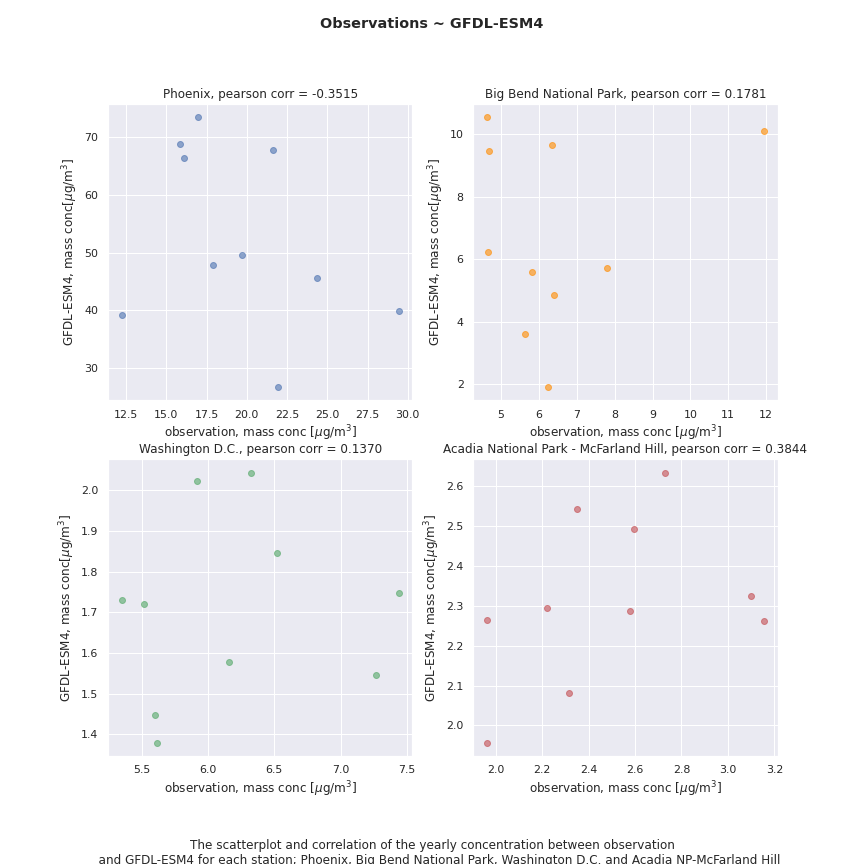

In [7]:
from IPython.display import Image
Image(filename='/home/4a726423-2d69c2-2d4ee4-2da665-2d1e313c39f43e/obs-gfdl-yearly.png')

Figure 5 shows the correlation between the values of the yearly averaged mass concentration for CMPs given by GFDL-ESM4 and the observations. As displayed, there is a negative correlation of -0.35 at the Phoenix station. The strongest correlation is found in the Acadia National Park-McFarland hill station with a value of 0.38. Big Bend National Park shows a correlation of 0.18, and Washington D.C. shows a correlation of 0.14.

##### **Figure 6**

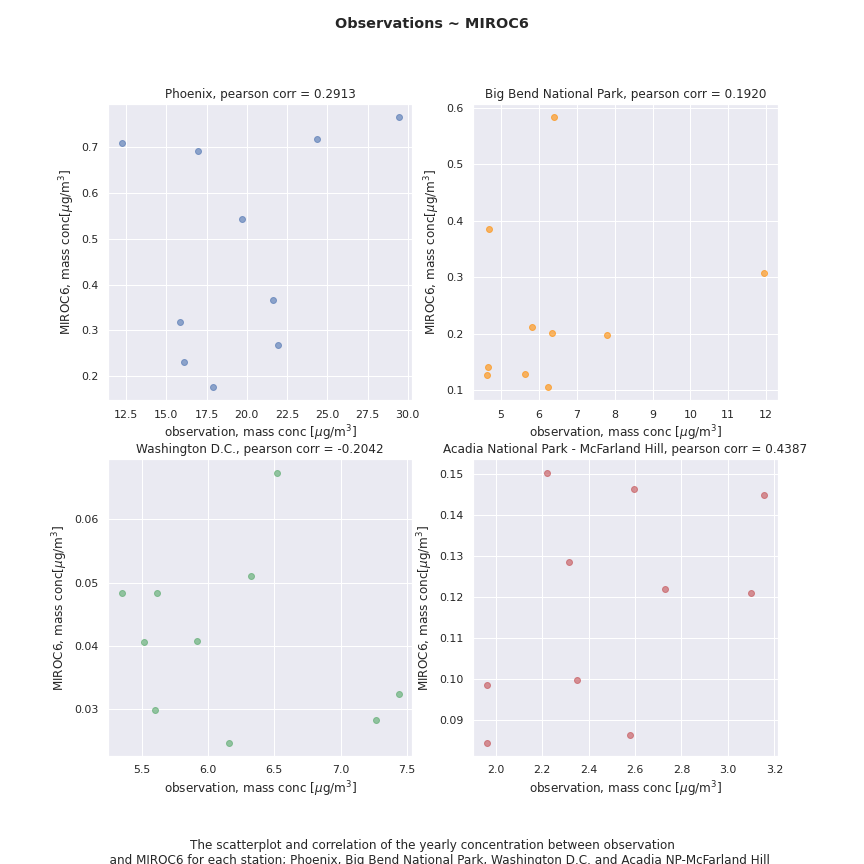

In [8]:
from IPython.display import Image
Image(filename='/home/4a726423-2d69c2-2d4ee4-2da665-2d1e313c39f43e/obs-miroc-yearly.png')

From figure 6 we can gather that the correlation between the MIROC6 and the observations is low. But at the Phoenix site, the yearly average mass concentration calculated from the MIROC6 data has a stronger correlation with the observation than that calculated from the GFDL-ESM4 data with a correlation of 0.44. Phoenix shows a correlation of 0.29, in Big Bend National Park the correlation has a value of 0.19 and in Washington D.C. the correlation is -0.20

### **Multimonthly average mass concentration comparison**

##### **Figure 7**

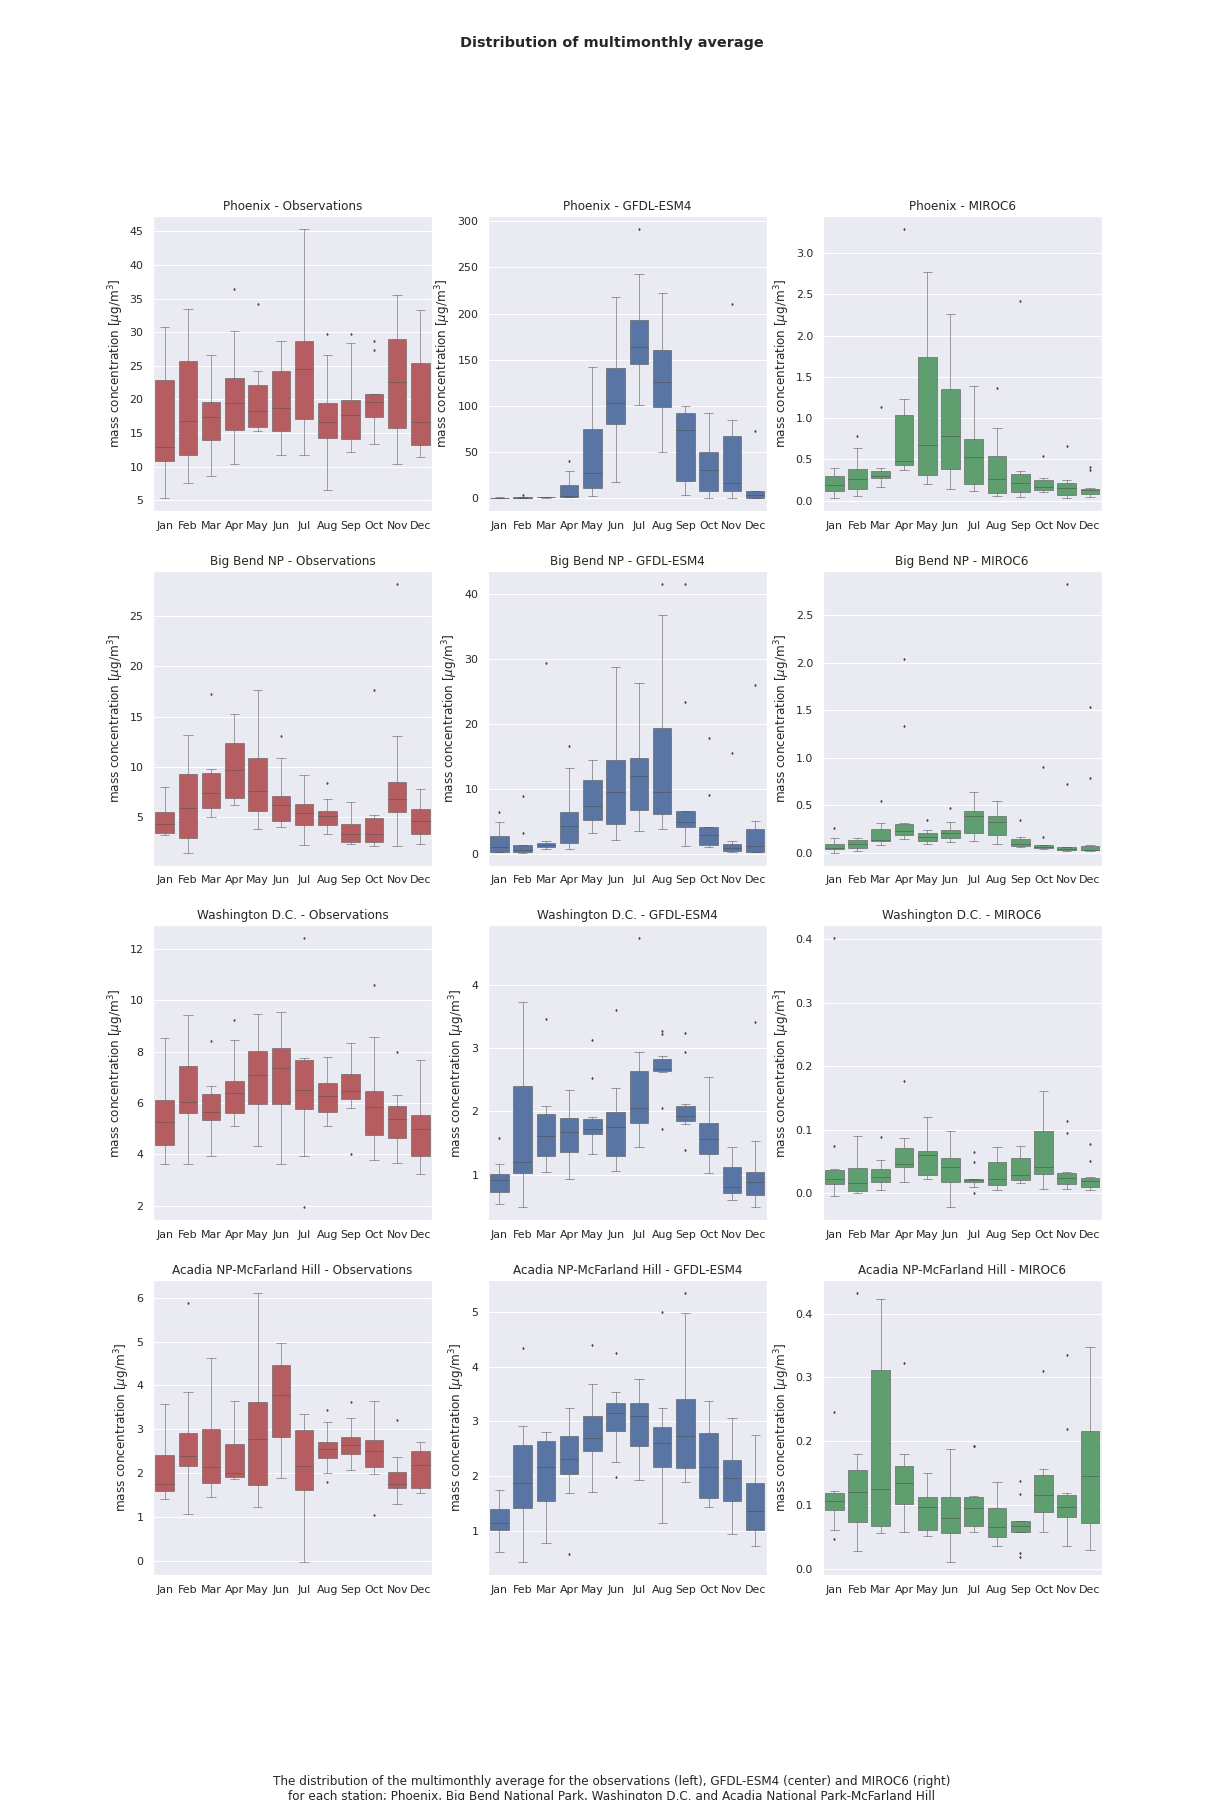

In [20]:
from IPython.display import Image
Image(filename='/home/4a726423-2d69c2-2d4ee4-2da665-2d1e313c39f43e/multi_monthly.png')

Looking at the plots for Phoenix in figure 8, we see that both GFDL-ESM4 and MIROC6 may be misrepresenting the distribution of the multimonthly mass concentration of the CMPs compared to the observations. The observations show a more even distribution through the months, whilst GFDL-ESM4 show higher values in June, July and August, especially compared to January, February, March and November. Looking at the plot for MIROC6, Phoenix, we see that May is the month containing the highest values.

There are no visible coherent similarities in the distribution of the multimonthly mass concentration between the models and the observations in the stations located at Big Bend National Park, Washington D.C., and Acadia National Park-McFarland hill

##### **Figure 8**

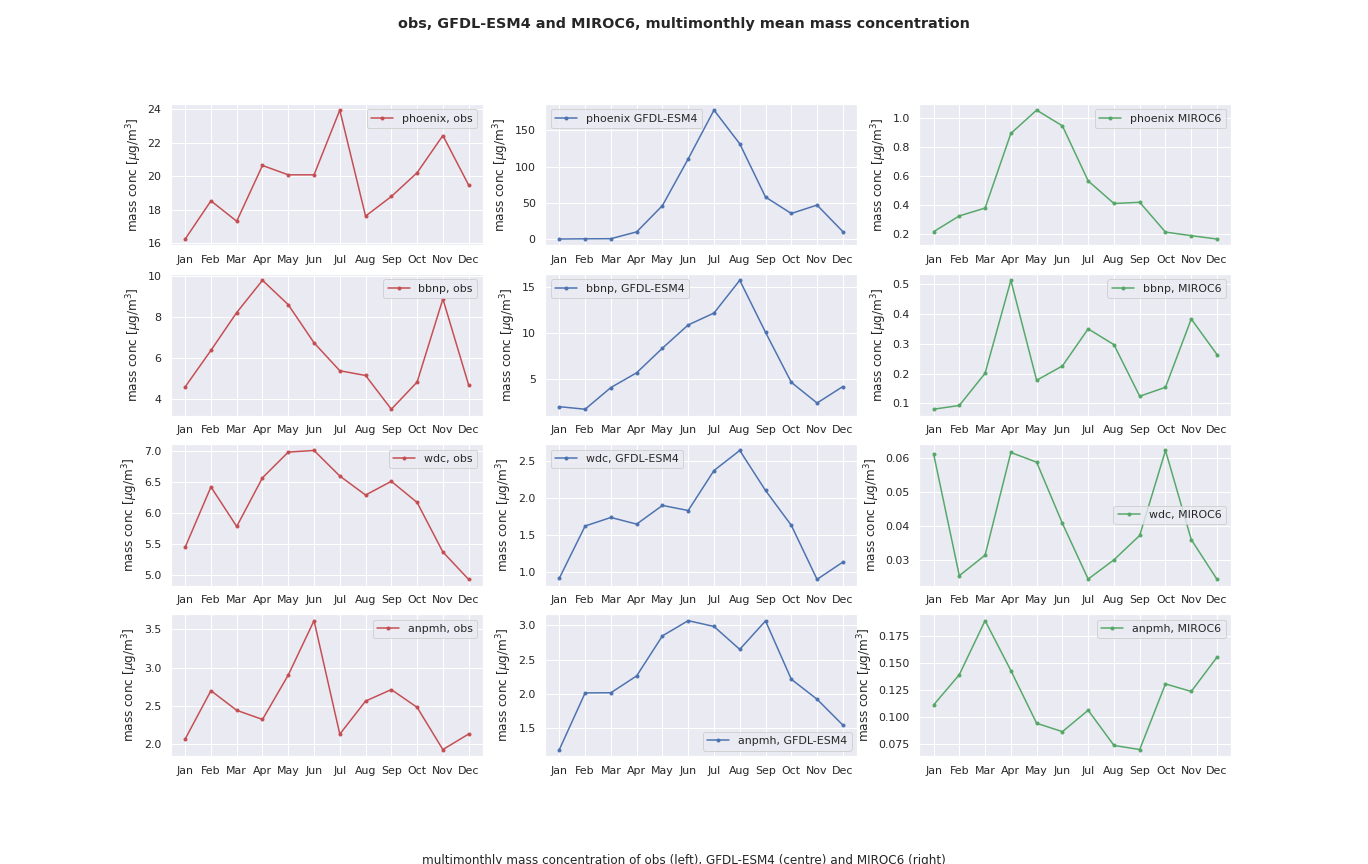

In [19]:
from IPython.display import Image
Image(filename='/home/4a726423-2d69c2-2d4ee4-2da665-2d1e313c39f43e/multimonthly_obs_GFDL-ESM4_MIROC6.png')

Figure 8 shows how the multi monthly average varies for each of the models and the observation for each of the sites. For Phoenix, we see that both the observation and the GFDL-ESM4 have a peak in July, whilst MIROC6 has a peak in May. For Big Bend National Park, both the observations and MIROC6 have a peak in April, whilst GFDL-ESM4 has a peak in August. For the site in Washington D.C., the observations show a peak in June, GFDL-ESM4 show a peak in August (with its second largest value in June) and MIROC6 show a peak in January, April and October (with the multi monthly averaged concentration in October being slightly higher). Both GFDL-ESM4 and the observations show a peak in June for the Acadia National Park-McFarland Hill station, whilst MIROC6 has a peak in March.

##### **Figure 9**

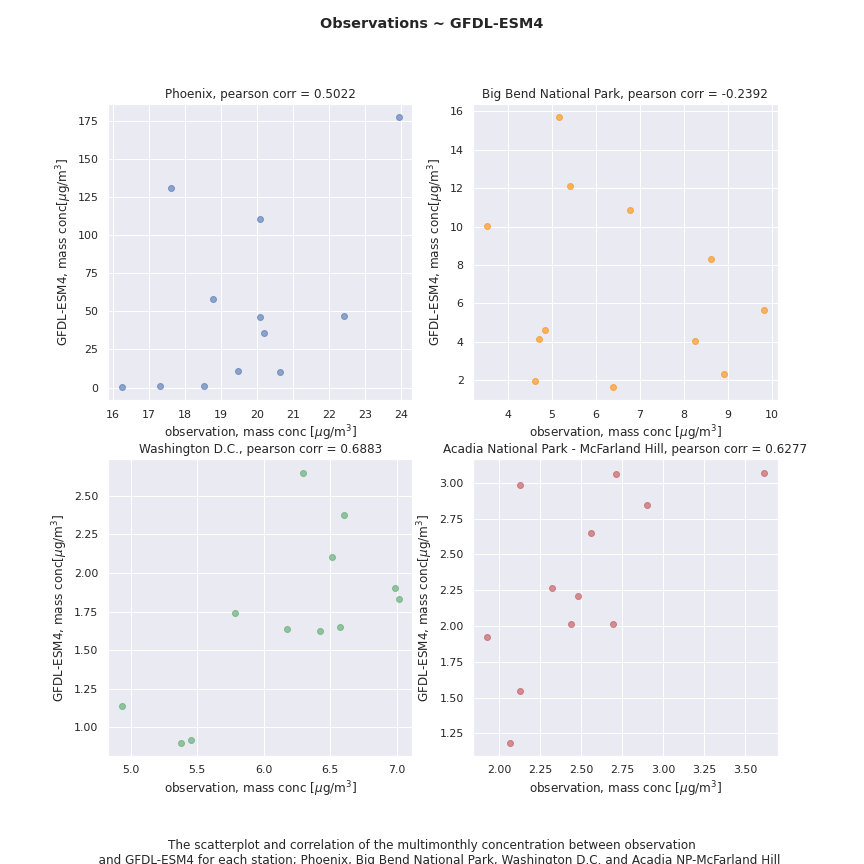

In [15]:
from IPython.display import Image
Image(filename='/home/4a726423-2d69c2-2d4ee4-2da665-2d1e313c39f43e/obs-gfdl-multimonthly.png')

Studying the scatter plot showcasing the correlation between the multimonthly average for GFDL-ESM4 and the observations, we find that there is correlation higher than 0.5 at all of the stations except for at the station at Big Bend National Park. Washington D.C. shows the strongest correlation between the model and the observation with a value of 0.68

##### **Figure 10**

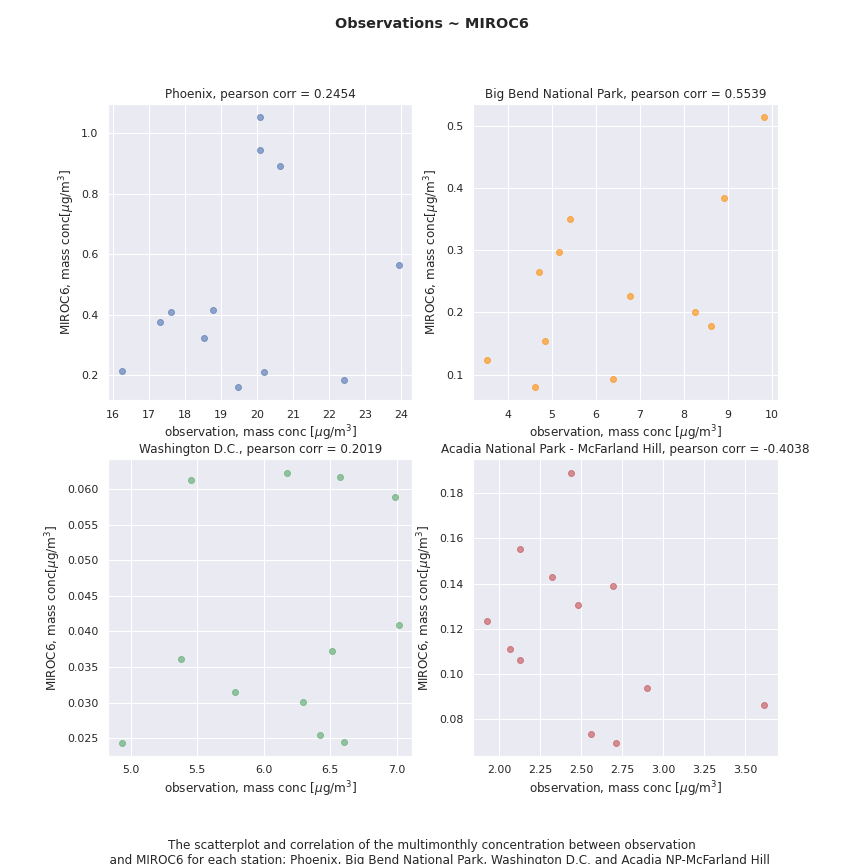

In [16]:
from IPython.display import Image
Image(filename='/home/4a726423-2d69c2-2d4ee4-2da665-2d1e313c39f43e/obs-miroc-multimonthly.png')

Figure 10 show that there is a correlation of 0.24 at Phoenix and 0.20 at Washington D.C. The site in Big Bend National Park has the highest correlation of 0.55, and Acadia National Park shows a negative correlation of -0.4.

### **Multiseasonal average mass concentration comparison**

##### **Figure 11**

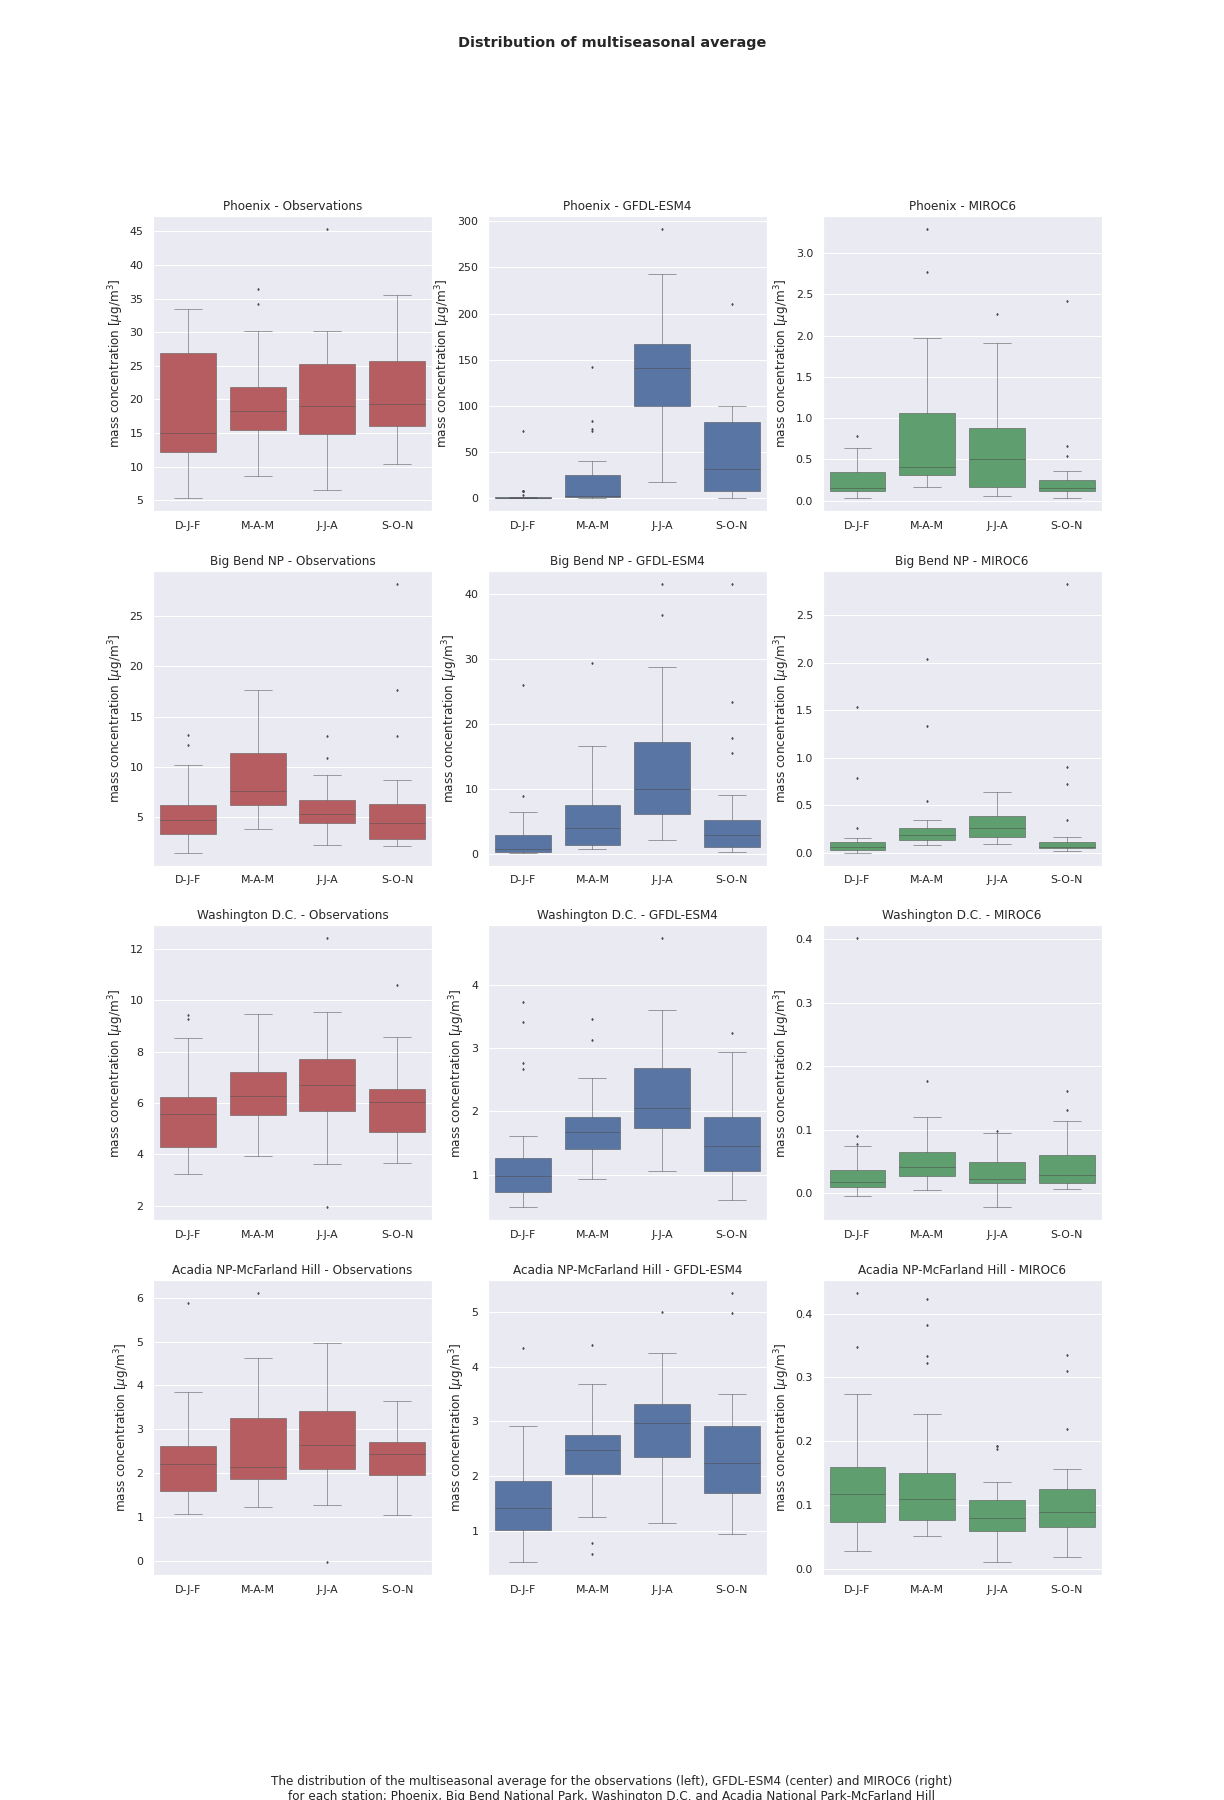

In [2]:
from IPython.display import Image
Image(filename='/home/4a726423-2d69c2-2d4ee4-2da665-2d1e313c39f43e/multi_seasonal.png')

Figure 11 show the distribution for the multiyear average of mass concentratio of CMPs for each season. Here, we see some similiarities in the distribution between the GFDL-ESM4 and the observations at the stations at Washington D.C. and Acadia National Park-McFarland Hill.

##### **Figure 12**

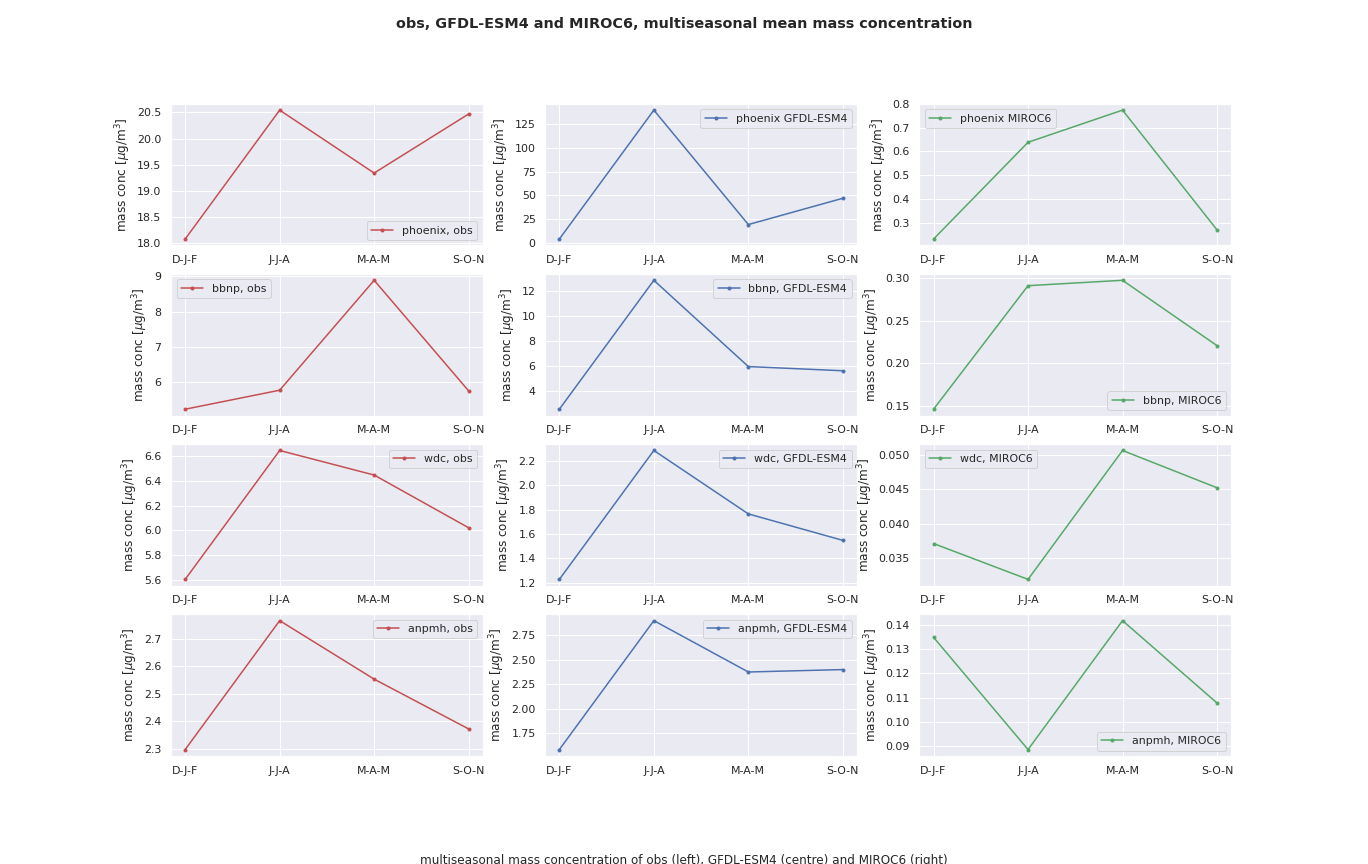

In [21]:
from IPython.display import Image
Image(filename='/home/4a726423-2d69c2-2d4ee4-2da665-2d1e313c39f43e/multiseasonal_obs_GFDL-ESM4_MIROC6.png')

Studying figure 12, we see that both GFDL-ESM4 and the observations display a maximum value in summertime season at the stations located at Phoenix, Washington D.C. and Acadia National Park-McFarland Hill. In the mentioned stations, MIROC6 displays a maximum in the springtime (March, April, May months). For Big Bend National Park, the observations show a maximum in the springtime, the same as MIROC6, whilst the maximum in GFDL-ESM4 is in the summertime.

##### **Figure 13**

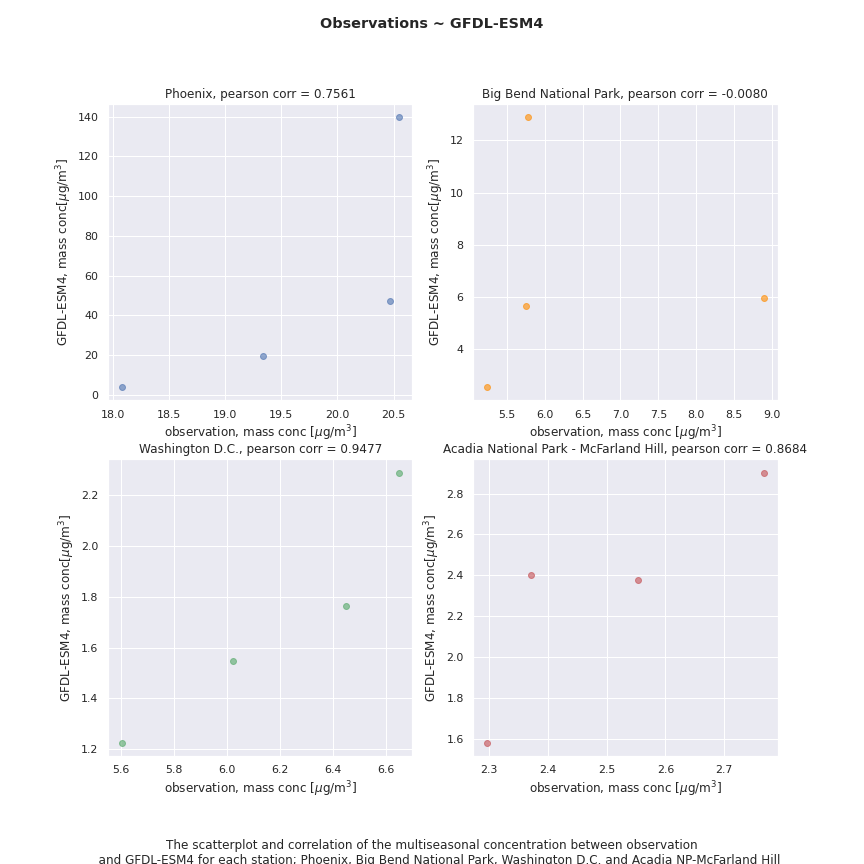

In [14]:
from IPython.display import Image
Image(filename='/home/4a726423-2d69c2-2d4ee4-2da665-2d1e313c39f43e/obs-gfdl-seasonal.png')

The scatterplot showcasing the correlation between the multi seasonal average for GFDL-ESM4 and the observation data is shown in figure 13. From this, we can gather that the GFDL-ESM4 has a correlation higher than 0.5 with the observations at all sites, except for at Big Bend National Park where the correlation is -0.01. The station at Washington D.C. shows the strongest correlation with a value of 0.95. The station at Acadia National Park-McFarlan Hill has the second highest correlation with a value of 0.87, and the site at Phoenix shows a correlation 0.76.

##### **Figure 14**

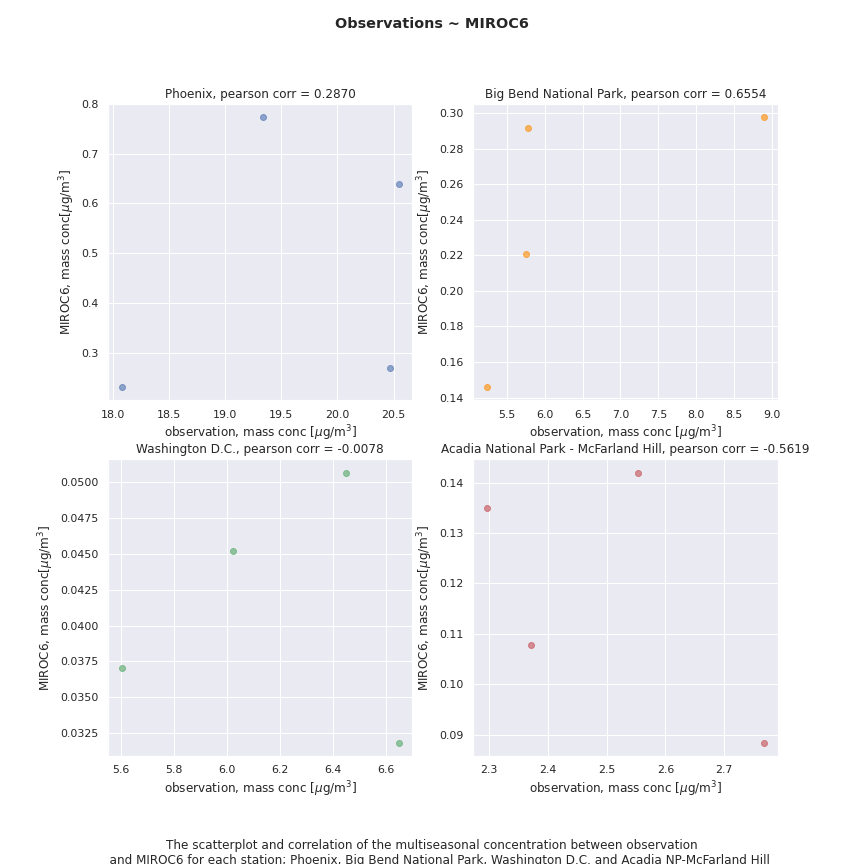

In [13]:
from IPython.display import Image
Image(filename='/home/4a726423-2d69c2-2d4ee4-2da665-2d1e313c39f43e/obs-miroc-seasonal.png')

In figure 14, we can see the correlation of the multi seasonal average mass concentration at Phoenix, Big Bend National Park, Washington D.C. and Acadia National Park-McFarland Hill of the observations and the data from MIROC6. Interestingly, there is no correlation higher than 0.5 at Phoenix, Washington D.C. and Acadia National Park-McFarlan Hill between the MIROC6 data and the observation data (the station at Washington D.C. and Acadia National Park even show a negative correlation), but there is a correlation at Big Bend National Park.

## **DISCUSSION AND CONCLUSION**

The definition of what is a good correlation might vary according to what one wishes to accomplish. A modeller might be satisfied as long as the model shows the same tendensies as the observations. Further in this discussion, we will go by the definition of any correlation between 0.5-0.7 to be a moderate correlation and anything above 0.7 to be very good correlation **(2)**.  Any negative correlation, even with a magnitude larger than -0.5, will be discarded as bad correlation as its trend will be the opposite of the trend of the observations.

The scatter plots for the correlation of monthly average mass concentration of CMPs in GFDL-ESM4 together with the observations in figure 2 and for the correlation of MIROC6 together with the observations in figure 3 indicates that the models are misrepresenting the observations on all the sites studied.  GFDL-ESM4 has the overall strongest correlation with the observations when comparing the two models, except for at Phoenix where MIROC6 have a better correlation.

Figure 5 and figure 6, showing the correlation of the yearly average between GFDL-ESM4 and the observations, and MIROC6 and the observations, respectivly, indicates that the models are misrepresenting the observations in this regard as well. GFDL-ESM4 shows a negative correlation in Phoenix of -0.35 and MIROC6 shows a negative correlation in Washington D.C. of -0.20, implying that the trends in the respective models are opposite of the trend in the observations. The overall best correlation in regards to yearly average is found in Acadia National Park-McFarland hill between the MIROC6 data and the observations.

For the correlation of the multi year average of each month, the result is shown in figure 9 for the GFDL-ESM4 - observations, and in figure 10 for the MIROC6 - observations. Interestingly, GFDL-ESM4 have a moderate correlation with the observations at all sites except for in Big Bend National Park, and on the contrary, MIROC6 shows no good correlation with the observations except for a moderate correlation at the site at Big Bend.

The scatter plots for the correlation of the yearly averaged mass concentration of CMPs for each season are shown in figure 13 and figure 14. The same trend is seen here as in the correlation of the multiyear average for each month; GFDL-ESM4 have a good correlation correlation with the observations on all sites except for Big Bend National Park. And again, MIROC6 shows a moderate correlation with the observations at Big Bend, and a negative correlation at Acadia. The difference is that the magnitude of the correlations has increased.

What can we gather from this? To sum it up, the models do not seemingly represent neither the monthly mean mass concentration of CMPs nor the yearly mean mass concentration of CMPs well. But taking the yearly average for each month we see that GFDL-ESM4 has the overall best correlation, with the exception of the site at Big Bend where MIROC6 has a much better correlation. "Zooming out" and looking at the yearly average for each season, the magnitude of the correlations increases. Does this mean that GFDL-ESM4 is better at modelling the yearly average for each month/season in cities and in areas with low mass concentration CMPs? To give a full answer to this, we need to study more sites. As we have only discussed four different sites, it is hard to give a general conclusion about the performance of the models.

It is also important to acknowledge the source of error in this project; the first level chosen for the models is not the exact alititude of where the observation station is located. The location chosen for the model is not the exact location of the observation stations either, as if we were to extract the exact location we would have to interpolate the grid of the model data, which would have been too much work. As we did not have the data for the air density in the models, the observed mass concentration is compared to the the mass mixing ratio in the model data multiplied with the air density at sea surface.

The result indicating that the models are not directly representing the site can also be due to the fact that we only look at one point inside a much higher modelled volume. An idea would be to look at more sites within the same grid cell. This might allow us to get a broader idea of how the models represent the mass concentration of CMPs, and understand what needs to be improved upon the parameterization of CMPs in the models.

## **REFERENCES**

**(1)** http://cires1.colorado.edu/jimenez/Papers/Alfarra_PhD%20Thesis_1Chapter1_Introduction.pdf

**(2)** https://www.westga.edu/academics/research/vrc/assets/docs/scatterplots_and_correlation_notes.pdf

## **ACKNOWLEDGMENTS**

* The model data was provided by Michael Schultz
* I would like to thank the teachers, the assistants and others involved in the course. Special thanks to Gabriel Freitas for being an excellent and patient teaching assitant, and to Jonas Gliss for technical support.
* Thank you to Tatiana and Ville
* And finally, thank you to Yaping for the peer reviewing